In [1]:
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Activation
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad
from matplotlib import pyplot as plt

In [2]:
# Load Training und Val Data
with open('FormatedData/100000/x_train.pickle', 'rb') as file:
    x_train = pickle.load(file)
with open('FormatedData/100000/x_val.pickle', 'rb') as file:
    x_val = pickle.load(file)
with open('FormatedData/100000/y_train.pickle', 'rb') as file:
    y_train = pickle.load(file)
with open('FormatedData/100000/y_val.pickle', 'rb') as file:
    y_val = pickle.load(file)

In [3]:
print(len(x_train))
print(len(x_val))
print(len(y_train))
print(len(y_val))

95000
5000
95000
5000


In [4]:
with open('FormatedData/100000/Metadata/context_words.pickle', 'rb') as file:
    context_words = pickle.load(file)
with open('FormatedData/100000/Metadata/unique_tokens.pickle', 'rb') as file:
    unique_tokens = pickle.load(file)

In [5]:
# Metrics
def top_5_categorical_accuracy(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)
def top_10_categorical_accuracy(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=10)
# Activation Functions
def elliott_activation(x):
    return (0.5 * x / (1 + tf.abs(x))) + 0.5
def modified_elliott_activation(x):
    return (x / tf.sqrt(1 + tf.square(x))) + 0.5

In [6]:
dropout=.5
keras.backend.clear_session()
# Create Model
model = Sequential()
model.add(LSTM(128, input_shape=(context_words, len(unique_tokens)), return_sequences=True, recurrent_dropout=dropout,  dropout=dropout, recurrent_activation=modified_elliott_activation))
model.add(LSTM(128, recurrent_dropout=dropout, dropout=dropout, recurrent_activation=modified_elliott_activation))
model.add(Dense(len(unique_tokens), activation="softmax"))

In [7]:
# Train Model
model.compile(loss='categorical_crossentropy', optimizer=Adagrad(learning_rate=1), metrics=['accuracy', 'categorical_accuracy', top_5_categorical_accuracy, top_10_categorical_accuracy])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=128, epochs=50, shuffle=True).history

Epoch 1/50
743/743 [==============================] - 434s 575ms/step - loss: 6.9707 - accuracy: 0.0624 - categorical_accuracy: 0.0624 - top_5_categorical_accuracy: 0.1710 - top_10_categorical_accuracy: 0.2373 - val_loss: 6.7915 - val_accuracy: 0.0724 - val_categorical_accuracy: 0.0724 - val_top_5_categorical_accuracy: 0.1798 - val_top_10_categorical_accuracy: 0.2408
Epoch 2/50
743/743 [==============================] - 424s 571ms/step - loss: 6.6587 - accuracy: 0.0673 - categorical_accuracy: 0.0673 - top_5_categorical_accuracy: 0.1754 - top_10_categorical_accuracy: 0.2439 - val_loss: 6.6675 - val_accuracy: 0.0824 - val_categorical_accuracy: 0.0824 - val_top_5_categorical_accuracy: 0.1968 - val_top_10_categorical_accuracy: 0.2632
Epoch 3/50
743/743 [==============================] - 423s 569ms/step - loss: 6.4692 - accuracy: 0.0774 - categorical_accuracy: 0.0774 - top_5_categorical_accuracy: 0.1915 - top_10_categorical_accuracy: 0.2623 - val_loss: 6.5322 - val_accuracy: 0.0918 - val_ca

In [8]:
# Save Model and history
model.save('Model7/Model_100000.h5')
pickle.dump(history, open("Model7/history.p", "wb"))

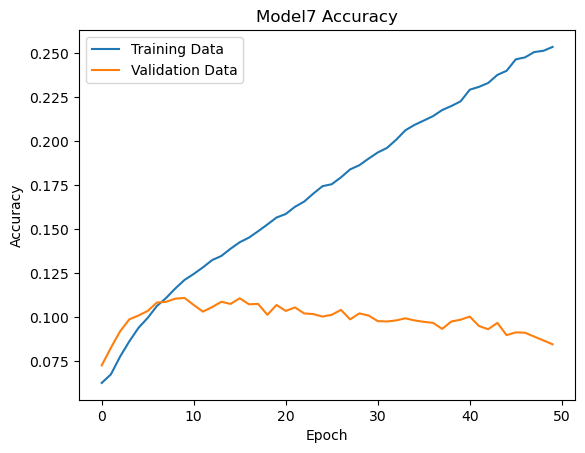

In [9]:
# Get Model stats
# model = load_model('Model7/Model_100000.h5')
history = pickle.load(open("Model7/history.p", "rb"))

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model7 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Data', 'Validation Data'], loc='upper left') 

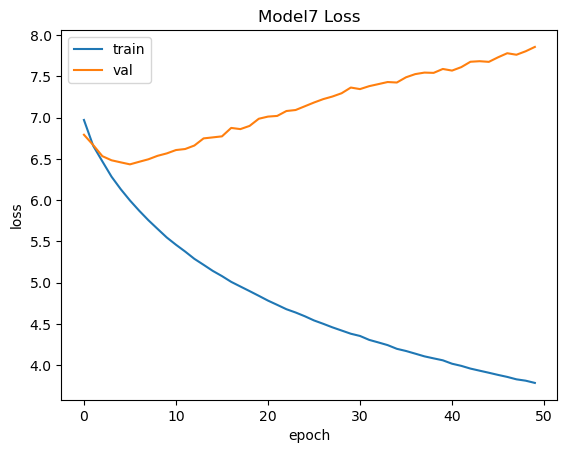

In [10]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model7 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [11]:
# Registriere die benutzerdefinierten Metrikfunktionen
custom_objects = {'top_5_categorical_accuracy': top_5_categorical_accuracy,
                  'top_10_categorical_accuracy': top_10_categorical_accuracy,
                 'elliott_activation': elliott_activation,
                 'modified_elliott_activation': modified_elliott_activation}

# Lade das Modell mit den registrierten benutzerdefinierten Metriken
with tf.keras.utils.custom_object_scope(custom_objects):
    model = load_model('Model7/Model_100000.h5')